*__Project 3__*

Project 3 involves building a face attribute classifier using the FairFace dataset which contains 86,744 training images and 10,954 validation images of faces. The images have been converted to grayscale and resized to 32x32. There are three attributes to classify: race, gender, and age. The project involves experimenting with different neural network architectures and measuring the performance of each on the classification tasks. There are 4 classification models and 1 generative model we are exploring. The performance of each network will be measured using accuracy and confusion matrices. The models are as follows:

    * 1. Fully Connected Neural Network
    * 2. Small Convolutional Neural Network
    * 3. Custom Convolutional Neural Network
    * 4. Multi-Task Convolutional Neural Network for two of the three attributes
    * 5. Variational Autoencoder

Each of the models will be explored in detail in thier respective sections below. The training for each model will be done on Google Colab and the results will be saved html files. The results will be discussed in the Results section. Each of these models will be trained on the task of classifying age and gender. These were chosen because gender has a binary output and age has a continuous output. 

In [7]:
# !rm -rf Deep-Learning
# !git clone https://github.com/tmengel/Deep-Learning.git
# !ls Deep-Learning/project3/
# %cd Deep-Learning/project3
# !pwd

---
The following imports and functions are the data pre-processing and the task functions which load the data, process it, one hot endoce it depending on the target feature and then train and evaluate the vaes.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

age_labels = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','more than 70'] # possible values for age
gender_labels = ['Female','Male'] # possible values for gender
race_labels= ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian'] # possile races
features = ['age','gender','race'] # all target features
cat_labels = {
    'age': age_labels,
    'gender' : gender_labels,
    'race' : race_labels,
    # 'service_test' : service_test_labels
    }

TRAIN = 86744 # number of images to use for training
VALIDATE = 10954 # number of images to use for training and validation

# training_path = '/content/Deep-Learning/project3/fairface_label_train.csv'
# validation_path = '/content/Deep-Learning/project3/fairface_label_val.csv'
training_path = 'fairface_label_train.csv' # path to training data
validation_path = 'fairface_label_val.csv' # path to validation data

def one_hot_encode(df,feature,labels):
    '''
    One-hot encode a feature in a dataframe
    '''
    cats = df[feature].values
    one_hot = np.zeros((cats.size,labels.__len__()))
    for i in range(cats.size):
        one_hot[i][labels.index(cats[i])] = 1
    return one_hot

def one_hot_decode(one_hot,labels):
    ''' 
        Decode one-hot encoded labels to their original labels
    '''
    return [labels[np.argmax(one_hot[i])] for i in range(one_hot.shape[0])]

def read_images(n, path):
    ''' 
        Read in n images from a csv file, and return a dataframe with the labels and the images 
    '''    
    
    # read in csv file
    df = pd.read_csv(path)
    # sample n rows
    df = df.sample(n, random_state=42)
    # reset index
    df = df.reset_index(drop=True)
    # create empty list for images
    images = np.zeros((n, 32, 32, 1), dtype=np.uint8)
    # loop through each row and read in image file        
    for index, row in df.iterrows():
#         image_path = f'/content/Deep-Learning/project3/{row["file"]}'
        image_path = f'{row["file"]}'
        image = Image.open(image_path)
        img = np.array(image)
        img = img.reshape(32,32,1)
        images[index] = img

    df = df.drop(columns=["file"])
    df['image_id'] = df.index  # add image_id column
    return df, images

def plot_images(df=None,images=None):
    '''
    Plot images with their labels for visual inspection
    '''
    # plot images
    fig, axs = plt.subplots(len(images)//5, 5, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
        if df is not None:
            ax.set_title(df.loc[i, "age"] + ", " + df.loc[i, "gender"] + ", " + df.loc[i, "race"])
    plt.show()
    
def min_max_scale_images(images):
    '''
        Min-max scale images
    '''
    # Min-max scale each image
    images_min_max = np.zeros(images.shape)
    iter=0
    for i in images:
        ama = np.amax(i)
        ami = np.amin(i)
        i = (i - ami) / (ama - ami)
        images_min_max[iter] = i
        iter+=1
    return images_min_max

def count_categories(path):
    '''
        Count the number of categories for each feature. Used to determine the number of output nodes for the neural network
    '''
    
    df = pd.read_csv(path)
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} categories")

def load_data(n, path,plot=False):
    '''
        Function to load data from a csv file, encode and preprocess the data
    '''
    
    df, images = read_images(n, path) # read in images and labels
    images = min_max_scale_images(images) # min-max scale images
    if plot: # plot images (for visual inspection)
        plot_images(df=df,images=images)
        
    # One-hot encode labels
    one_hot = {}
    labels = {}
    for feature in features:
        one_hot[feature] = one_hot_encode(df, feature, cat_labels[feature])
        labels[feature] = one_hot_decode(one_hot[feature], cat_labels[feature])
    
    return images, one_hot, labels

def plot_history(history):
    '''
    Plot training and validation loss and accuracy for task 1-3
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()
    
def evaluate_model(model, images_test, one_hot_test, labels_test, target):
    '''
    Evaluate the model on the test data and plot the confusion matrix. Only works for task 1-3
    '''
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(images_test, one_hot_test[target])

    # Get predictions for the test data
    test_pred_one_hot = model.predict(images_test)
    test_pred_labels = one_hot_decode(test_pred_one_hot, cat_labels[target])

    # Create the confusion matrix
    cm = confusion_matrix(labels_test[target], test_pred_labels, labels=cat_labels[target])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[target], yticklabels=cat_labels[target])
    plt.xlabel('Predicted labels')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    print('Final classification accuracy:', test_acc)
                   
def plot_multi_history(history, features):
    '''
    Plot training and validation loss and accuracy for task 4
    '''
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    # plot training and validation loss
    axs[0][0].plot(history.history[f'{features[0]}_output_loss'])
    axs[0][0].plot(history.history[f'val_{features[0]}_output_loss'])
    axs[0][0].set_title(f'{features[0]} Loss')
    axs[0][0].set_xlabel('Epoch')
    axs[0][0].set_ylabel('Loss')
    axs[0][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[0][1].plot(history.history[f'{features[0]}_output_accuracy'])
    axs[0][1].plot(history.history[f'val_{features[0]}_output_accuracy'])
    axs[0][1].set_title(f'{features[0]} Accuracy')
    axs[0][1].set_xlabel('Epoch')
    axs[0][1].set_ylabel('Accuracy')
    axs[0][1].legend(['train', 'val'], loc='best')
    
    axs[1][0].plot(history.history[f'{features[1]}_output_loss'])
    axs[1][0].plot(history.history[f'val_{features[1]}_output_loss'])
    axs[1][0].set_title(f'{features[1]} Loss')
    axs[1][0].set_xlabel('Epoch')
    axs[1][0].set_ylabel('Loss')
    axs[1][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1][1].plot(history.history[f'{features[1]}_output_accuracy'])
    axs[1][1].plot(history.history[f'val_{features[1]}_output_accuracy'])
    axs[1][1].set_title(f'{features[1]} Accuracy')
    axs[1][1].set_xlabel('Epoch')
    axs[1][1].set_ylabel('Accuracy')
    axs[1][1].legend(['train', 'val'], loc='best')
    
    plt.show()
    
def evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets):
    '''
    Evaluate the model on the test data and plot the confusion matrix. Only works for task 4
    '''
    
    evaluation = model.evaluate(images_test, [one_hot_test[targets[0]], one_hot_test[targets[1]]], verbose=0)
    print(f'Final classification accuracies: {targets[0]} {evaluation[3]}, {targets[1]} {evaluation[4]}')

    test_pred_one_hot_feature1, test_pred_one_hot_feature2  = model.predict(images_test)
    test_pred_labels_feature1 = one_hot_decode(test_pred_one_hot_feature1, cat_labels[targets[0]])
    test_pred_labels_feature2 = one_hot_decode(test_pred_one_hot_feature2, cat_labels[targets[1]])

    cm_feature1 = confusion_matrix(labels_test[targets[0]], test_pred_labels_feature1, labels=cat_labels[targets[0]])
    cm_feature2 = confusion_matrix(labels_test[targets[1]], test_pred_labels_feature2, labels=cat_labels[targets[1]])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0] = sns.heatmap(cm_feature1, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[0]], yticklabels=cat_labels[targets[0]], ax=axs[0])
    axs[0].set_xlabel(f'Predicted {targets[0]} labels')
    axs[0].set_ylabel(f'True {targets[0]} labels')
    axs[0].set_title(f'{targets[0]} Confusion matrix')
    axs[0].invert_yaxis()
    axs[1] = sns.heatmap(cm_feature2, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[1]], yticklabels=cat_labels[targets[1]], ax=axs[1])
    axs[1].set_xlabel(f'Predicted {targets[1]} labels')
    axs[1].set_ylabel(f'True {targets[1]} labels')
    axs[1].set_title(f'{targets[1]} Confusion matrix')
    axs[1].invert_yaxis()

    # plt.title('Confusion matrices')
    plt.show()


---
The following code includes the tensorflow models for each task

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, Dropout, Conv2DTranspose, Lambda, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def FullyConnectedNetwork(output_size): # Task 1
    return Sequential([
            Flatten(input_shape=(32, 32, 1)),
            Dense(1024, activation='tanh'),
            Dense(512, activation='sigmoid'),
            Dense(100, activation='relu'),
            Dense(output_size, activation='softmax')
        ])
    
def SmallCNN(output_size): # Task 2
    return Sequential([
            Conv2D(40,input_shape=(32,32,1),kernel_size=(5,5),strides=1,padding='valid', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(100,activation='relu'),
            Dense(output_size,activation='softmax')
        ])
    
def CustomCNN(output_size): # Task 3
    return Sequential([
        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(output_size,activation='softmax')
    ])

def sampling(args): # Task 5
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

def VariationalAutoEncoder(latentdim): # Task 5
    latent_dim = latentdim
    intermediate_dim = 100
    # Encoding
    inputs = Input(shape=(32,32,1),name='encoder_input')
    x0 = Conv2D(64, (3, 3), activation="relu", padding="same",name='encoder_conv1')(inputs)
    m0 = MaxPooling2D((2, 2))(x0)
    x1 = Conv2D(128, (3, 3), activation="relu", padding="same",name='encoder_conv2')(m0)
    m1 = MaxPooling2D((2, 2))(x1)
    f1 = Flatten()(m1)
    x = Dense(intermediate_dim, activation='relu', name="encoder_hidden_dense")(f1)
    
    # Latent space
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder_output')
    
    # Decoding
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x2 = Dense(intermediate_dim, activation='relu', name="decoder_hidden_dense")(latent_inputs)
    x3 = Dense(32*32, activation='relu', name="decoder_hidden_dense2")(x2)
    r2 = Reshape((32,32,1))(x3)
    x4 = Conv2DTranspose(128, (3, 3), padding="same", name='decoder_conv1')(r2)
    x5 = Conv2DTranspose(64, (3, 3), padding="same", name='decoder_conv2')(x4)
    outputs = Conv2DTranspose(1, (3, 3), padding="same", name='decoder_conv3')(x5)
    decoder = Model(latent_inputs,outputs,name='decoder_output')
  
    outputs = decoder(encoder(inputs)[2])
    
    return Model(inputs, outputs, name='vae')

def MultiTaskCNN(output_size, features): # Task 4
    # Define inputs
    inputs = Input(shape=(32, 32, 1))

    # Convolutional layers for feature1 branch
    feature1_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',)(inputs)
    feature1_pool1 = MaxPooling2D(pool_size=(2, 2))(feature1_conv1)
    feature1_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature1_pool1)
    feature1_pool2 = MaxPooling2D(pool_size=(2, 2))(feature1_conv2)

    # Convolutional layers for feature2 branch
    feature2_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    feature2_pool1 = MaxPooling2D(pool_size=(2, 2))(feature2_conv1)
    feature2_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature2_pool1)
    feature2_pool2 = MaxPooling2D(pool_size=(2, 2))(feature2_conv2)

    # Flatten and concatenate branches
    feature1_flatten = Flatten()(feature1_pool2)
    feature2_flatten = Flatten()(feature2_pool2)
    merged = concatenate([feature1_flatten, feature2_flatten])

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(merged)
    feature1_dense2 = Dense(64, activation='relu')(dense1)
    feature1_output = Dense(output_size[0], activation='softmax', name=f'{features[0]}_output')(feature1_dense2)
    feature2_dense2 = Dense(64, activation='relu')(dense1)
    feature2_output = Dense(output_size[1], activation='softmax', name=f'{features[1]}_output')(feature2_dense2)

    return Model(inputs=inputs, outputs=[feature1_output, feature2_output])   

def do_task(target, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics): # function to do the task 1-3
    '''
    Function to do the task 1-3. Create the model, train it, plot the training and validation loss and accuracy, and evaluate the model on the test set.
    '''
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    # Create the model   
    output_size = len(cat_labels[target])
    if model == 'FullyConnectedNetwork':
        model = FullyConnectedNetwork(output_size)
    elif model == 'SmallCNN':
        model = SmallCNN(output_size)
    elif model == 'CustomCNN':
        model = CustomCNN(output_size)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, one_hot_train[target], epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # Evaluate the model on test data
    evaluate_model(model, images_test, one_hot_test, labels_test, target) 

def do_multi_task(targets, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics): # function to do the task 4
    '''
    Function to do the task 4. Create the model, train it, plot the training and validation loss and accuracy, and evaluate the model on the test set.
    '''
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)

    # Create the model   
    output_size = [len(cat_labels[target]) for target in targets]
    model = MultiTaskCNN(output_size, targets)       
    model.compile(optimizer=optimizer,
                    loss = {f'{targets[0]}_output': loss, f'{targets[1]}_output': loss},
                    metrics=metrics)
    model.summary()

    # Train the model
    history = model.fit(images_train, {f'{targets[0]}_output': one_hot_train[targets[0]], f'{targets[1]}_output': one_hot_train[targets[1]]},
        epochs=epochs, batch_size=batch_size, validation_split=0.2)

    plot_multi_history(history, targets)

    evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets) 
    
def do_VAE_task(ntrain,nval,loss,optimizer,epochs,batch_size,metrics,latentdim): # function to do the task 5
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    model = VariationalAutoEncoder(latentdim)
    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, images_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # Evaluate the model on test data
    images = np.zeros((20, 32, 32, 1))
    decoder = model.layers[2]
    for i in range(20):
        rand_vector = np.random.normal(size=(1, latentdim))
        img = decoder(rand_vector)
        images[i] = img
    
    plot_images(images=images)
    
    # evaluate_model(model, images_test, one_hot_test, labels_test, )

---
__Preview Dataset.__

These are a sample of the images in the dataset. The images are 32x32 grayscale images and min-maxed.


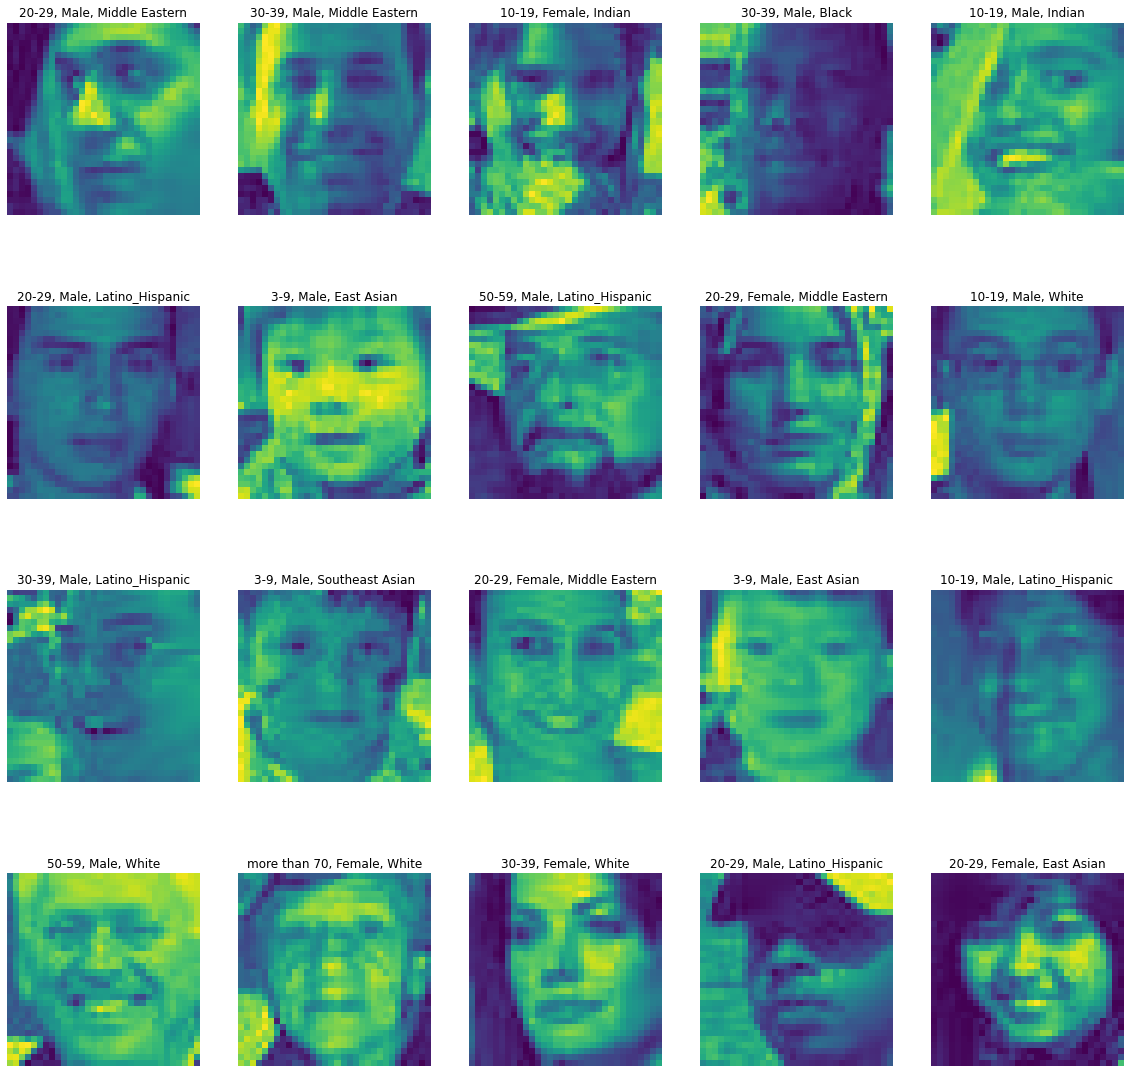

In [14]:
images_train, one_hot_train, labels_train = load_data(20, training_path, plot=True) # sample 20 images from the training set

---
---
__Task 1: Fully Connected Neural Network__

This network is a dense squential model which is defined in `FullyConnectedNetwork` function above. It consists of 3 hidden layers with 1024, 512, and 100 neurons. The corresponding activation functions are tanh, sigmoid, and relu. The output of the model is a dense layer with $n$ nodes depending on the number of output categories with a soft-max activation. The model is optimized with the adam optimizer and the loss function is categorical cross entropy. The model is trained for 50 epochs with a mini-batch size of 32. For each of the target features, the model summary, epoch training history, accuracy and loss vs epoch plots, confusion matrix, and final categorical accuracy are shown below. The model is trained on the training set with an 80/20 validation split. The model is then evaluated on the validation csv file set. The results are shown below.

For more detailed explaination of the model, the keras sequential model is shown below.

        Flatten(input_shape=(32, 32, 1)),
        Dense(1024, activation='tanh'),
        Dense(512, activation='sigmoid'),
        Dense(100, activation='relu'),
        Dense(output_size, activation='softmax')



*Target 1: Age*

In [ ]:
do_task(target='age', model="FullyConnectedNetwork", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

*Target 2: Gender*

In [ ]:
do_task(target='gender', model="FullyConnectedNetwork", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

---
---
__Task 2: Small Convolutional Neural Network__

This network is a 2D convolution squential model which is defined in `SmallCNN` function above. It consists of 2 hidden layers. The first is a `Conv2D` layer which has 40 features, a $5x5$ kernal size, stride 1 and padding valid. The activation for this convolution layer is relu. The convolution later is followed by a max pooling layer with $2x2$ pool size. The final hidden layer is a dense layer with 100 neurons and a relu activation function. The output of the model is a dense layer with $n$ nodes depending on the number of output categories with a soft-max activation. The model is optimized with the adam optimizer and the loss function is categorical cross entropy. The model is trained for 50 epochs with a mini-batch size of 32. For each of the target features, the model summary, epoch training history, accuracy and loss vs epoch plots, confusion matrix, and final categorical accuracy are shown below. The model is trained on the training set with an 80/20 validation split. The model is then evaluated on the validation csv file set. The results are shown below.

For more detailed explaination of the model, the keras sequential model is shown below.

        Conv2D(40,input_shape=(32,32,1),kernel_size=(5,5),strides=1,padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(100,activation='relu'),
        Dense(output_size,activation='softmax')


*Target 1: Age*

In [ ]:
do_task(target='age', model="SmallCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

*Target 2: Gender*

In [ ]:
do_task(target='gender', model="SmallCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

---
---
__Task 3: Your own Convolutional Neural Network__

This network is a 2D convolution squential model which is defined in `CustomCNN` function above. This model is much larger than the small convolutional network in the previous task. The first hidden layer is a `Conv2D` layer which has 64 features, a $3x3$ kernal size, stride 1 and padding same. The activation for this convolution layer is relu. The convolution layer is followed by a max pooling layer with $2x2$ pool size. After the first pooling is another2 `Conv2D` layer with 128 and 256 features, another $2x2$ max pooling after each `2Dconv` layer. The final hidden layer is a dense layer with 512 neurons and a relu activation function. There is a 50% drop out layer after the fully connected layer to avoid over fitting. The output of the model is a dense layer with $n$ nodes depending on the number of output categories with a soft-max activation. The model is optimized with the adam optimizer and the loss function is categorical cross entropy. The model is trained for 50 epochs with a mini-batch size of 32. For each of the target features, the model summary, epoch training history, accuracy and loss vs epoch plots, confusion matrix, and final categorical accuracy are shown below. The model is trained on the training set with an 80/20 validation split. The model is then evaluated on the validation csv file set. The results are shown below.

For more detailed explaination of the model, the keras sequential model is shown below.

        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(output_size,activation='softmax')

These values where chosen due to their increased performace.


*Target 1: Age*

In [ ]:
do_task(target='age', model="CustomCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

*Target 2: Gender*

In [ ]:
do_task(target='gender', model="CustomCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

---
---
__Task 4: Your own Convolutional Neural Network on both Tasks Simultaneously__

This network is a 2D convolution model which is defined in `MultiTaskCNN` function above. The output of the model is a dense layer with $n$ nodes depending on the number of output categories with a soft-max activation. The model is optimized with the adam optimizer and the loss function is categorical cross entropy. The model is trained for 100 epochs with a mini-batch size of 32. For each of the target features, the model summary, epoch training history, accuracy and loss vs epoch plots, confusion matrix, and final categorical accuracy are shown below. The model is trained on the training set with an 80/20 validation split. The model is then evaluated on the validation csv file set. The results are shown below.

For more detailed explaination of the model, the keras sequential model is shown below.

        feature1_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',)(Input(input_shape=(32, 32, 1)))
        feature1_pool1 = MaxPooling2D(pool_size=(2, 2))(feature1_conv1)
        feature1_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature1_pool1)
        feature1_pool2 = MaxPooling2D(pool_size=(2, 2))(feature1_conv2)

        feature2_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
        feature2_pool1 = MaxPooling2D(pool_size=(2, 2))(feature2_conv1)
        feature2_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature2_pool1)
        feature2_pool2 = MaxPooling2D(pool_size=(2, 2))(feature2_conv2)

        feature1_flatten = Flatten()(feature1_pool2)
        feature2_flatten = Flatten()(feature2_pool2)
        merged = concatenate([feature1_flatten, feature2_flatten])

        dense1 = Dense(128, activation='relu')(merged)
        feature1_dense2 = Dense(64, activation='relu')(dense1)
        feature1_output = Dense(output_size[0], activation='softmax', name=f'{features[0]}_output')(feature1_dense2)
        feature2_dense2 = Dense(64, activation='relu')(dense1)
        feature2_output = Dense(output_size[1], activation='softmax', name=f'{features[1]}_output')(feature2_dense2)

These values where chosen due to their increased performace.

In [ ]:
do_multi_task(targets=['age','gender'], model="MultiTaskCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

---
---
__Task 5: Variational Auto Encoder__

This network is a variational auto encoder which is defined in `VariationalAutoEncoder` function above.The encoder takes in $32x32x1$ gray-scaled images and produces a mean and log variance vector of size `latentdim`, which is entered by the user. The decoder takes in the mean and log variance vector and produces a $32x32x1$ gray-scaled image. The model is optimized with the adam optimizer and the loss function is mean squared error. The model is trained for 100 epochs with a mini-batch size of 32. The model summary, epoch training history, accuracy and loss vs epoch plots, and 20 sample generated images are shown below. The 20 images are generated by random vectors of latent size `latentdim`, passed only to the decoder in `do_VAE_task`. The model is shown below.

        # Encoding
        inputs = Input(shape=(32,32,1),name='encoder_input')
        x0 = Conv2D(64, (3, 3), activation="relu", padding="same",name='encoder_conv1')(inputs)
        m0 = MaxPooling2D((2, 2))(x0)
        x1 = Conv2D(128, (3, 3), activation="relu", padding="same",name='encoder_conv2')(m0)
        m1 = MaxPooling2D((2, 2))(x1)
        f1 = Flatten()(m1)
        x = Dense(intermediate_dim, activation='relu', name="encoder_hidden_dense")(f1)
        
        # Latent space
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        z = Lambda(sampling, name='z')([z_mean, z_log_var])
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder_output')
        
        # Decoding
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x2 = Dense(intermediate_dim, activation='relu', name="decoder_hidden_dense")(latent_inputs)
        x3 = Dense(32*32, activation='relu', name="decoder_hidden_dense2")(x2)
        r2 = Reshape((32,32,1))(x3)
        x4 = Conv2DTranspose(128, (3, 3), padding="same", name='decoder_conv1')(r2)
        x5 = Conv2DTranspose(64, (3, 3), padding="same", name='decoder_conv2')(x4)
        outputs = Conv2DTranspose(1, (3, 3), padding="same", name='decoder_conv3')(x5)
        decoder = Model(latent_inputs,outputs,name='decoder_output')
    
        outputs = decoder(encoder(inputs)[2])
    

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_output (Functional)  [(None, 5),              894806    
                              (None, 5),                         
                              (None, 5)]                         
                                                                 
 decoder_output (Functional)  (None, 32, 32, 1)        179673    
                                                                 
Total params: 1,074,479
Trainable params: 1,074,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2605 - accuracy: 0.0037 - val_loss: 0.1378 - val_accuracy: 0.0039
Epoch 2/50
1/1 [==============================] 

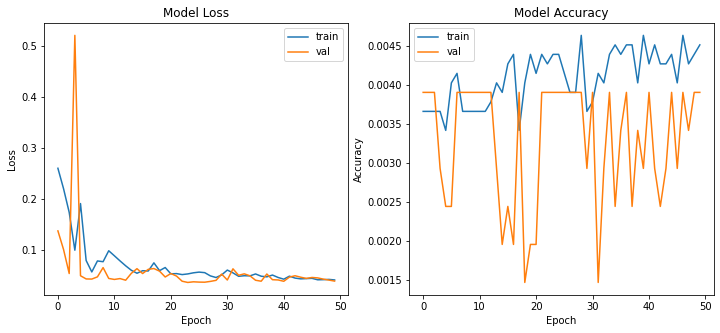

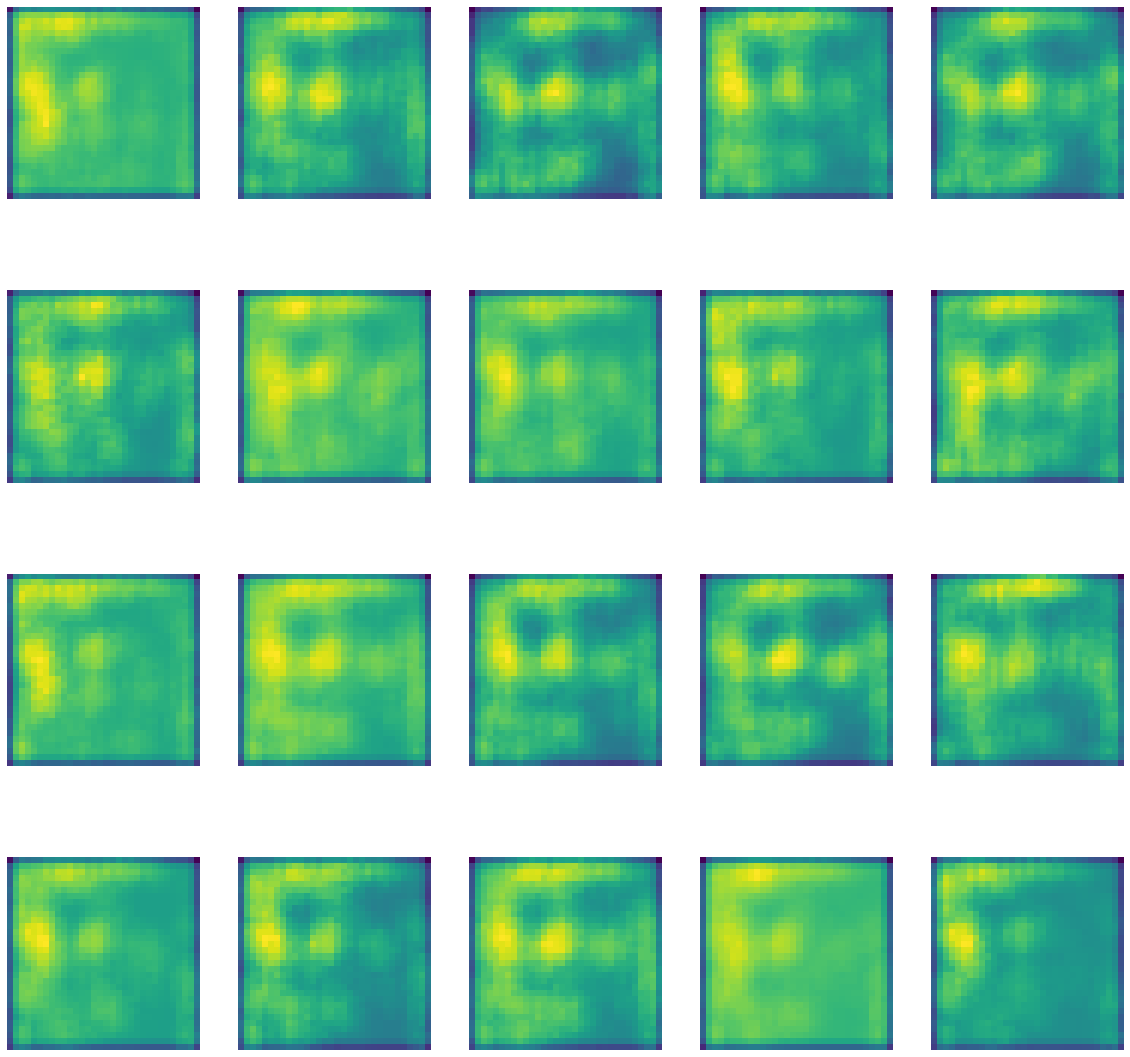

In [44]:
do_VAE_task(ntrain=TRAIN, nval=VALIDATE, loss='mse', optimizer='adam', epochs=50, batch_size=32, metrics=['accuracy'], latentdim=5)